In [3]:
import nibabel as nib
import multiprocessing
import os
import numpy as np
import os.path as op
import seaborn as sns
import matplotlib
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import svm
from sklearn import preprocessing
from sklearn.cross_decomposition import PLSRegression
import pickle
from ipyparallel import Client
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import LinearSVC
%matplotlib inline

In [4]:
rc = Client()

In [16]:
#preliminary housekeeping
home_dir = '/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [17]:
exp = 'sim_4mm-betas'
masks = ['entorhinal','peri_sim','para_sim','hipp','yeo17_ifs',
         'lOFC_fill_sim','mOFC_fill_sim','sim_4mm_striatum_mask']
# masks = ['sim_4mm_striatum_limbic_mask','sim_4mm_striatum_frontal_mask']
smooth = 'smoothed'

In [18]:
def get_condition(i):
    if i < 11:
        cond = 'b_plus'
        trial = i
    elif i < 21:
        cond = 'c_plus'
        trial = i - 10
    elif i < 31:
        cond = 'c_minus'
        trial = i - 20
    elif i < 41:
        cond = 'b_minus'
        trial = i - 30
    return cond,trial

In [19]:
overlap_masks = ['peri_sim','para_sim','hipp']


In [20]:
def trim_mask(mask,m):
    exclusions = overlap_masks[:]
    exclusions.remove(m)
    
    for e in exclusions:

        m1 = op.abspath('./data/' + sub + '/masks/' + e +'.nii.gz')
        m1 = nib.load(m1).get_data().astype(bool)

        good = np.invert(m1)
        mask = np.logical_and(mask,good)
    return mask

In [21]:
# #Saves betas to csv so we don't have to constantly rerun this slow code block
# for m in ['VTC_sim']:
#     betas = {'sub':[],'mask':[],'run':[],'condition':[],'trial':[],'value':[],'voxel':[],'row':[]}
#     out_f = op.join(home_dir,'betas', '_'.join([exp,smooth,m]) + '.csv')
    
#     for sub in subs:
#         sub_path = op.join(home_dir,'analysis', exp, sub, 'reg','epi', smooth )

#         mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
#         mask = nib.load(mask).get_data().astype(bool)
#         if m in overlap_masks:
#             mask = trim_mask(mask,m)
            
#         for run in map(str,range(1,4)):
#             run_dir = op.join(sub_path, 'run_'  + run)
            
#             if os.path.exists(run_dir):
                
#                 for i in range(1,41):
#                     f = run_dir + '/cope' + str(i) + '_xfm.nii.gz'
#                     cond, trial = get_condition(i)

#                     #load stat image
#                     stat = nib.load(f).get_data().astype(float)
#                     stat = stat[mask]
                    
#                     for n,val in enumerate(stat):
#                         betas['voxel'].append(n)                        
#                         betas['sub'].append(sub)
#                         betas['value'].append(val)
#                         betas['mask'].append(m)
#                         betas['run'].append(run)
#                         betas['condition'].append(cond)
#                         betas['trial'].append(trial)
#                         betas['row'].append(i)
#             else:
#                 print run_dir

#     betas = pd.DataFrame(betas)
#     betas.to_csv(out_f)
#     del betas

In [22]:
#set ROIs of interest and load from hard disk
def load_whitened_betas(rois):
    smooth = 'smoothed'
    betas = []
    for sub in subs:
        for m in set(rois):
            for sub in subs:
                out_f = op.join(home_dir,'betas', 'whitened','_'.join(['sim_4mm-betas',sub,smooth,m]) + '.csv')
                betas.append(pd.read_csv(out_f))
    betas = pd.concat(betas)
    betas = betas.set_index(['sub', 'mask','run'])

    return betas


In [25]:
#set ROIs of interest and load from hard disk
def load_betas(rois):
    betas = []
    for sub in subs:
        for m in set(rois):
            f = op.join(home_dir,'betas', '_'.join([exp,sub,smooth,m]) + '.csv')
            betas.append(pd.read_csv(f))

    betas = pd.concat(betas)
    betas = betas.set_index(['sub', 'mask','run'])
    
    return betas

In [27]:
# betas = load_betas(['hipp'])
betas

condition  row  trial         value  voxel
sub    mask run                                           
fd_104 hipp 1      b_plus    1      1  -1822.228027      0
            1      b_plus    1      1    -27.430979      1
            1      b_plus    1      1   2315.476562      2
            1      b_plus    1      1  -4315.130859      3
            1      b_plus    1      1  -3478.931152      4
            1      b_plus    1      1     49.742405      5
            1      b_plus    1      1   -743.493469      6
            1      b_plus    1      1    189.367554      7
            1      b_plus    1      1      0.168587      8
            1      b_plus    1      1   1195.469238      9
            1      b_plus    1      1    822.502441     10
            1      b_plus    1      1  -1271.503174     11
            1      b_plus    1      1   4468.523926     12
            1      b_plus    1      1   -787.067261     13
            1      b_plus    1      1  -8319.042969     14
            1      b_plus    1      1    856.746704     15
            1      b_plus    1      1 -12416.640625     16
            1      b_plus    1      1  -5365.242676     17
            1      b_plus    1      1 -13156.208008     18
            1      b_plus    1      1 -13562.450195     19
            1      b_plus    1      1  -4500.385254     20
            1      b_plus    1      1 -13810.271484     21
            1      b_plus    1      1  -5990.818359     22
            1      b_plus    1      1  -4198.009766     23
            1      b_plus    1      1   1375.223022     24
            1      b_plus    1      1  -6674.381348     25
            1      b_plus    1      1    948.853638     26
            1      b_plus    1      1  -1257.002075     27
            1      b_plus    1      1   -789.074768     28
            1      b_plus    1      1   6814.554688     29
...                   ...  ...    ...           ...    ...
fd_148 hipp 3     b_minus   40     10   7746.258301   1861
            3     b_minus   40     10   5601.691406   1862
            3     b_minus   40     10    625.792480   1863
            3     b_minus   40     10   2986.052734   1864
            3     b_minus   40     10  -1867.742065   1865
            3     b_minus   40     10   3577.283936   1866
            3     b_minus   40     10   3795.908203   1867
            3     b_minus   40     10   1260.764404   1868
            3     b_minus   40     10   2994.293945   1869
            3     b_minus   40     10   5411.347656   1870
            3     b_minus   40     10   7492.654785   1871
            3     b_minus   40     10   7546.551758   1872
            3     b_minus   40     10  10240.838867   1873
            3     b_minus   40     10   3434.381348   1874
            3     b_minus   40     10    309.021576   1875
            3     b_minus   40     10   4905.898926   1876
            3     b_minus   40     10  -6998.895020   1877
            3     b_minus   40     10   -629.765015   1878
            3     b_minus   40     10  -6058.258789   1879
            3     b_minus   40     10  -7192.000488   1880
            3     b_minus   40     10  -1279.078857   1881
            3     b_minus   40     10   2457.010498   1882
            3     b_minus   40     10  -1314.395142   1883
            3     b_minus   40     10   1019.593628   1884
            3     b_minus   40     10   5480.541992   1885
            3     b_minus   40     10   2466.352051   1886
            3     b_minus   40     10   6345.881836   1887
            3     b_minus   40     10   5409.117188   1888
            3     b_minus   40     10   9314.905273   1889
            3     b_minus   40     10   8683.555664   1890

[8357200 rows x 5 columns]

In [10]:
def multi_connect(x_roi,y_roi,betas):
    scores_df = {'sub':[],'score_test':[],'score_train':[],'y_roi':[],'x_roi':[]}
    for sub in ['fd_104']:
        if True:
            scores_train = []
            scores_test = []

            #deal with unequal number of runs across subjects
            runs = list(set(betas.loc[(sub,x_roi)].index))
            if len(runs) == 3:
                train_runs = [['1','2'],['1','3'],['2','3']]
            elif len(runs) == 2:
                train_runs = [['1'],['2']]

            for train_set in train_runs:
                X_train = []
                Y_train = []
                for run in runs:
                    #extract relevant data from betas df
                    X = betas.loc[(sub,x_roi,run)]
                    X = X.pivot(index = 'row',columns='voxel', values='value').values
                    
                    if x_roi == y_roi:
                        Y = np.copy(X)
                    else:    
                        Y = betas.loc[(sub,y_roi,run)]
                        Y = Y.pivot(index = 'row',columns='voxel', values='value').values

                    if str(run) in train_set:
                        X_train.append(np.copy(X))
                        Y_train.append(np.copy(Y))
                    else:
                        X_test = np.copy(X)
                        Y_test = np.copy(Y)

                #format design matrices for input to sklearn
                X_train = np.array(X_train)
                Y_train = np.array(Y_train)        

                X_train = X_train.reshape(-1, X_train.shape[-1])
                Y_train = Y_train.reshape(-1, Y_train.shape[-1])

                #standardize
                X_train = preprocessing.scale(X_train)
                Y_train = preprocessing.scale(Y_train)
                X_test = preprocessing.scale(X_test)
                Y_test = preprocessing.scale(Y_test)

                #compute PLS
                pls = PLSRegression(n_components=2,max_iter = 2000)
                pls.fit(X_train,Y_train)

                score_train = pls.score(X_train,Y_train)
                scores_train.append(score_train)

                score_test = pls.score(X_test,Y_test)
                scores_test.append(score_test)

        #save to DF
        scores_df['sub'].append(sub)
        scores_df['x_roi'].append(x_roi)
        scores_df['y_roi'].append(y_roi)
        scores_df['score_test'].append(np.mean(scores_test))
        scores_df['score_train'].append(np.mean(scores_train))
    
    scores_df = pd.DataFrame(scores_df)
    return scores_df
    

In [272]:
scores_df = multi_connect('VTC_sim','yeo17_ifs',betas)

In [279]:
scores_df

,score_test,score_train,sub,x_roi,y_roi
0,0.026262,0.180962,fd_104,VTC_sim,yeo17_ifs
1,-0.002296,0.296604,fd_105,VTC_sim,yeo17_ifs
2,0.051759,0.265188,fd_107,VTC_sim,yeo17_ifs
3,0.044233,0.211115,fd_108,VTC_sim,yeo17_ifs
4,0.113424,0.416544,fd_109,VTC_sim,yeo17_ifs
5,0.058679,0.261264,fd_110,VTC_sim,yeo17_ifs
6,0.014672,0.124156,fd_112,VTC_sim,yeo17_ifs
7,0.056731,0.210535,fd_113,VTC_sim,yeo17_ifs
8,0.029796,0.227390,fd_114,VTC_sim,yeo17_ifs
9,0.075381,0.215286,fd_115,VTC_sim,yeo17_ifs


In [15]:
def run_pls(in_tuple):
    x_roi, y_roi = in_tuple
    out_f = op.join(home_dir,'multi_connectivity', x_roi + '_to_' + y_roi + '_sim.pkl')

    if not op.exists(out_f):
        betas = load_betas([x_roi,y_roi])
        scores = multi_connect(x_roi,y_roi,betas)

        # write to a file 
        output = open(out_f, 'wb')
        pickle.dump(scores, output)
        output.close()

In [16]:
rois = ['hipp','peri_sim','entorhinal','para_sim','VTC_sim',
        'mOFC_fill_sim','lOFC_fill_sim','yeo17_ifs',
       'sim_4mm_striatum_limbic_mask','sim_4mm_striatum_frontal_mask']
roi_pairs = []
for i in range(0,len(rois)):
    for j in range(0,len(rois)):
        if i <= j:
            roi_pairs.append((rois[i],rois[j]))


In [37]:
dview = rc[0:8]
dview.block = True

dview.push(dict(home_dir=home_dir,
                exp = exp,
                subs = subs,
                smooth = smooth,
                load_betas = load_betas,
                multi_connect = multi_connect
                ))
dview.execute("import numpy as np")
dview.execute("import os.path as op")
dview.execute("import nibabel as nib")
dview.execute("import pandas as pd")
with dview.sync_imports():
    import os
    import numpy
    import scipy
    import scipy.stats
    import pickle
    import sklearn
    from sklearn import preprocessing
    from sklearn.cross_decomposition import PLSRegression
dview.map_sync(run_pls,roi_pairs)

In [43]:
df = []
for tup in roi_pairs:
    x_roi,y_roi = tup
    out_f = op.join(home_dir,'multi_connectivity', x_roi + '_to_' + y_roi + '_sim.pkl')
    
    if op.exists(out_f):

        pkl_file = open(out_f, 'rb')
        data = pickle.load(pkl_file)

        df.append(data)

        pkl_file.close()
df = pd.concat(df)

In [44]:
means = df.groupby(['x_roi','y_roi']).mean().unstack()['score_test']
df = df.set_index(['x_roi','y_roi'])


In [52]:
sig = {'x_roi':[],'y_roi':[],'sig':[]}
for x in rois:
    for y in rois:
        try:
            vals = df.loc[(x,y),'score_test'].values
        except:
            vals = df.loc[(y,x),'score_test'].values
        is_sig = int(scipy.stats.ttest_1samp(vals,0)[1] > .05)
        
        sig['x_roi'].append(x)
        sig['y_roi'].append(y)
        sig['x_roi'].append(y)
        sig['y_roi'].append(x)
        sig['sig'].append(is_sig)
        sig['sig'].append(is_sig)
sig = pd.DataFrame(sig)
sig = sig.groupby(['x_roi','y_roi']).mean().unstack()['sig']
mask = sig.values
mask[np.triu_indices_from(mask,1)] = True

In [53]:
def make_symmetric(df,rois):
    for n1,x in enumerate(rois):
        for n2,y in enumerate(rois):
            if n1 < n2:
                entry1 = df[x][y]
                entry2 = df[y][x]
                if np.isnan(entry1):
                    df[x][y] = entry2
                if np.isnan(entry2):
                    df[y][x] = entry1
    return df

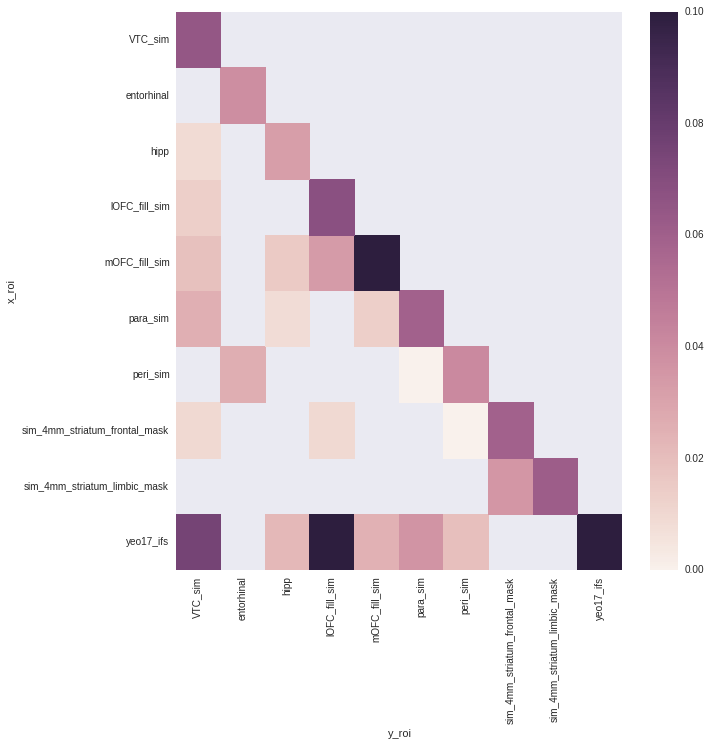

In [54]:

means = make_symmetric(means,rois)
sns.set(rc={"figure.figsize": (10, 10)})
sns.heatmap(means,mask = mask, vmin = 0, vmax = .1)

# examine content of connectivity


In [537]:
# betas = load_betas(['para_sim','peri_sim','mOFC_fill_sim','lOFC_fill_sim',
#                     'VTC_sim','yeo17_ifs','hipp'])

In [538]:
# def mvpa(roi,betas):
#     all_cnf = []
#     scores_df = {'sub':[],'score':[],'roi':[]}
#     for sub in subs:
        
#         ##get X data
#         runs = list(set(betas.loc[(sub,roi)].index))
#         X_data = []
#         for run in runs:
#             X = betas.loc[(sub,roi,run)]
#             X = X.pivot(index = 'row',columns='voxel', values='value').values
#             X_data.append(np.copy(X))
#         X_data = np.array(X_data)
#         X_data = X_data.reshape(-1, X_data.shape[-1])
#         X_data = preprocessing.scale(X_data)

#         #get y
#         sub_betas = betas.loc[(sub,roi)]
#         y = sub_betas[sub_betas['voxel'] == 0]['condition'].values
# #         ymap = {'b_plus':'+','c_plus':'+','b_minus':'-','c_minus':'-'}
#         ymap = {'b_plus':0,'c_plus':1,'b_minus':2,'c_minus':3}
#         y = np.array([ymap[x] for x in y])
        
#         #compute cross-val
#         runs = sub_betas[sub_betas['voxel'] == 0].index.values
#         cv = LeaveOneLabelOut(runs)

#         #compute cross-val score
#         linearSVM = svm.SVC(kernel='linear')
#         logistic = LogisticRegression(C=1)
# #         clf = Pipeline([('anova',anova),('classification',logistic)])
#         pca = decomposition.PCA(n_components = 20)
#         clf = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
        
#         res = cross_val_score(logistic, X_data, y, cv=cv, scoring = 'accuracy')
#         score = np.mean(res)
        
#         #compute confusion matrix
#         cnf = []
#         for train_index, test_index in cv:
#             X_train, X_test = X_data[train_index], X_data[test_index]
#             y_train, y_test = y[train_index], y[test_index]

#             y_pred = clf.fit(X_train, y_train).predict(X_test)
#             cnf_matrix = confusion_matrix(y_test, y_pred)
#             cnf.append(cnf_matrix)
#         cnf = np.array(cnf)
#         all_cnf.append(cnf.mean(0))

#         #compile results
#         scores_df['roi'].append(roi)
#         scores_df['sub'].append(sub)
#         scores_df['score'].append(score)
#         print sub,score
#     return pd.DataFrame(scores_df), all_cnf



In [19]:
def mvpa(roi,betas):
    all_cnf = []
    scores_df = {'sub':[],'score':[],'roi':[]}
    for sub in subs:
        
        runs_score = []
        runs_cnf = []
        runs = list(set(betas.loc[(sub,roi)].index))
        for run in runs:
        
            ##get X data
            sub_betas = betas.loc[(sub,roi,run)]
            X_data = sub_betas.pivot(index = 'row',columns='voxel', values='value').values
            X_data = preprocessing.scale(X_data)

            #get y
            y = sub_betas[sub_betas['voxel'] == 0]['condition'].values
            ymap = {'b_plus':0,'c_plus':1,'b_minus':2,'c_minus':3}
            y = np.array([ymap[x] for x in y])

            #cross val
            skf = StratifiedKFold(y,n_folds=3)

            #set up classifier
            logistic = LogisticRegression(C=1)
            pca = decomposition.PCA(n_components = 20)
            clf = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

            #compute cross-val score
            res = cross_val_score(clf, X_data, y, cv=skf, scoring = 'accuracy')
            score = np.mean(res)
            runs_score.append(score)
            
            #compute confusion matrix
            cnf = []
            for train_index, test_index in skf:
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y[train_index], y[test_index]

                y_pred = clf.fit(X_train, y_train).predict(X_test)
                cnf_matrix = confusion_matrix(y_test, y_pred)
                cnf.append(cnf_matrix)
            runs_cnf.append(np.array(cnf).mean(0))
            
        #compile results
        all_cnf.append(np.array(runs_cnf).mean(0))
        scores_df['roi'].append(roi)
        scores_df['sub'].append(sub)
        scores_df['score'].append(np.mean(runs_score))
#         print sub,score
    return pd.DataFrame(scores_df), all_cnf

In [20]:
#project a onto be
def vector_project(a,b):
    return (np.dot(a,b)/np.dot(b,b)) * b
    

In [32]:
roi = 'hipp'
scores_fd, all_cnf = mvpa(roi,betas)


Traceback (most recent call last):
  File "/home/iballard/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1120, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/iballard/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 301, in wrapped
    return f(*args, **kwargs)
  File "/home/iballard/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 346, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/iballard/anaconda/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/iballard/anaconda/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/iballard/anaconda/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):


ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



IndexError: string index out of range

In [659]:
print scores_fd.mean()
print scipy.stats.ttest_1samp(scores_fd['score'],.25)
# plt.hist(scores_fd['score'] - .25)

score    0.280888
dtype: float64
Ttest_1sampResult(statistic=3.5857856576164933, pvalue=0.001137679431688021)


In [646]:
def make_fig(rois,all_cnf):
    sns.set(rc={"figure.figsize": (8, 8)})
    cnf = np.mean(np.array(all_cnf),0)/10.0
    for i in range(cnf.shape[0]):
        for j in range(cnf.shape[0]):
            if i < j:
                avg = np.mean([cnf[i,j],cnf[j,i]])
                cnf[i,j] = avg
                cnf[j,i] = avg
    ymap = {'b_plus':0,'c_plus':1,'b_minus':2,'c_minus':3}

    mask = np.zeros_like(cnf, dtype=np.bool)
    mask[np.triu_indices_from(mask,1)] = True

    cnf = pd.DataFrame(cnf, index = ['AB+','C+','B-','AC-'], 
                       columns = ['AB+','C+','B-','AC-'])
    sns.heatmap(cnf,mask= mask)
    plt.title('_to_'.join(rois))
    plt.savefig('/home/iballard/fd/connectivity/mvpa_' + '_'.join(rois) + '.png')

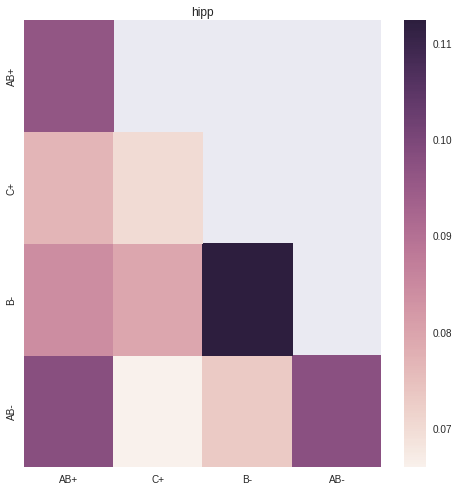

In [633]:
make_fig(roi,all_cnf)

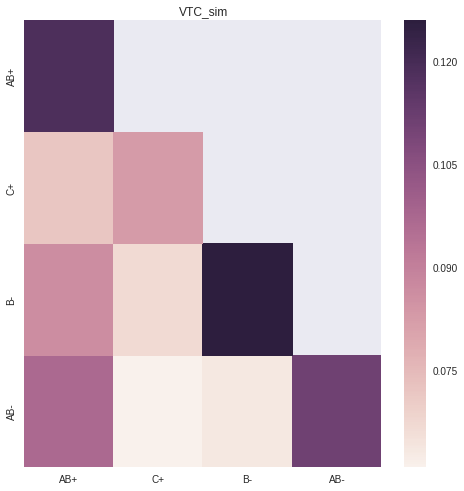

In [636]:
make_fig(roi,all_cnf)

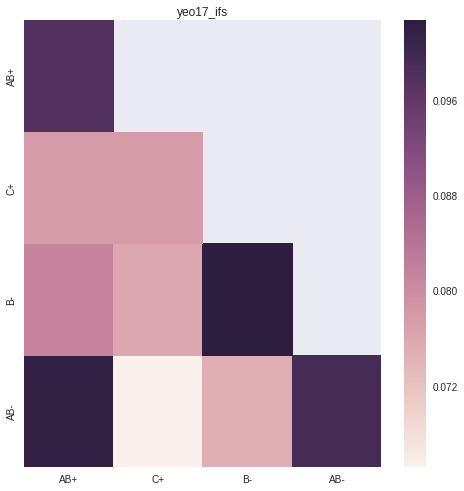

In [638]:
make_fig(roi,all_cnf)

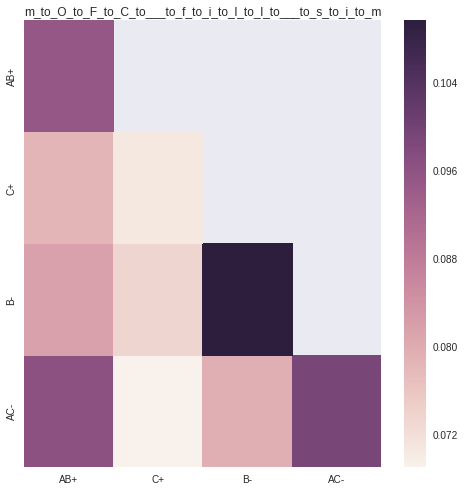

In [660]:
make_fig(roi,all_cnf)

In [661]:
# def connect_mvpa(x_roi, y_roi, betas):
#     pls_score = 0
#     all_cnf = []
#     scores_df = {'sub':[],'score':[],'roi':[],'pls_score':[]}
#     for sub in subs:
        
#         ##get X,Y data
#         runs = list(set(betas.loc[(sub,roi)].index))
#         X_data = []
#         Y_data = []
#         for run in runs:
#             X = betas.loc[(sub,x_roi,run)]
#             X = X.pivot(index = 'row',columns='voxel', values='value').values
#             X_data.append(np.copy(X))
            
#             Y = betas.loc[(sub,y_roi,run)]
#             Y = Y.pivot(index = 'row',columns='voxel', values='value').values
#             Y_data.append(np.copy(Y))
        
#         #format data nicely
#         X_data = np.array(X_data)
#         X_data = X_data.reshape(-1, X_data.shape[-1])
#         X_data = preprocessing.scale(X_data)
        
#         Y_data = np.array(Y_data)
#         Y_data = Y_data.reshape(-1, Y_data.shape[-1])
#         Y_data = preprocessing.scale(Y_data)
        
#         #compute cross-val
#         sub_betas = betas.loc[(sub,roi)]
#         runs = sub_betas[sub_betas['voxel'] == 0].index.values
#         cv = LeaveOneLabelOut(runs)

#         #compute PLS dimensionality reduction
#         pls = PLSRegression(n_components=2,max_iter = 2000)
# #         X_data, Y_data = pls.fit_transform(X_data,Y_data)
# #         pls.fit(X_data,Y_data)
# #         Y_pred = pls.predict(X_data)

#         predictions = []
#         pls_score = []
#         for train_index, test_index in cv:
#             X_train, X_test = X_data[train_index], X_data[test_index]
#             y_train, y_test = Y_data[train_index], Y_data[test_index]
            
#             #deal with scaling
#             X_train = preprocessing.scale(X_train)
#             y_train = preprocessing.scale(y_train)
#             X_test = preprocessing.scale(X_test)
#             y_test = preprocessing.scale(y_test)
                
#             #fit and assess
#             pls.fit(X_train,y_train)
#             pls_score.append(pls.score(X_test, y_test))

#             #track predictions
#             y_pred = pls.predict(X_test)
#             predictions.append(y_pred)
            
#         pls_score = np.mean(pls_score)
#         Y_pred = np.array(predictions)
#         Y_pred = Y_pred.reshape(-1, Y_pred.shape[-1])

#         #project Y_data onto Y_pred
#         Y_projection = []
#         for row1,row2 in zip(Y_data,Y_pred):
#             new_row = vector_project(row1,row2)
#             Y_projection.append(new_row)
#         Y_data = np.array(Y_projection)
#         Y_data = preprocessing.scale(Y_data)
        
#         #get y
#         y = sub_betas[sub_betas['voxel'] == 0]['condition'].values
#         ymap = {'b_plus':0,'c_plus':1,'b_minus':2,'c_minus':3}
#         y = np.array([ymap[x] for x in y])
        
#         #compute cross-val score
#         logistic = LogisticRegression(C=1)
# #         clf = svm.SVC(kernel='linear')
#         pca = decomposition.PCA(n_components = 4)
#         clf = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
        
#         res = cross_val_score(clf, Y_data, y, cv=cv, scoring = 'accuracy')
#         score = np.mean(res)
        
#         #compute confusion matrix
#         cnf = []
#         for train_index, test_index in cv:
#             X_train, X_test = Y_data[train_index], Y_data[test_index]
#             y_train, y_test = y[train_index], y[test_index]
            
# #             #deal with scaling
# #             X_train = preprocessing.scale(X_train)
# #             y_train = preprocessing.scale(y_train)
# #             X_test = preprocessing.scale(X_test)
# #             y_test = preprocessing.scale(y_test)
            
#             y_pred = clf.fit(X_train, y_train).predict(X_test)
#             cnf_matrix = confusion_matrix(y_test, y_pred)
#             cnf.append(cnf_matrix)
#         cnf = np.array(cnf)
#         all_cnf.append(cnf.mean(0))

#         #compile results
#         scores_df['roi'].append(roi)
#         scores_df['sub'].append(sub)
#         scores_df['score'].append(score)
#         scores_df['pls_score'].append(pls_score)
#         print sub, score, pls_score
#     return pd.DataFrame(scores_df), all_cnf



In [662]:
def connect_mvpa(x_roi, y_roi, betas):
    pls_score = 0
    all_cnf = []
    scores_df = {'sub':[],'score':[],'roi':[],'pls_score':[]}
    for sub in subs:
        
        ##get X,Y data
        runs = list(set(betas.loc[(sub,roi)].index))
        X_data = []
        Y_data = []
        for run in runs:
            X = betas.loc[(sub,x_roi,run)]
            X = X.pivot(index = 'row',columns='voxel', values='value').values
            X_data.append(np.copy(X))
            
            Y = betas.loc[(sub,y_roi,run)]
            Y = Y.pivot(index = 'row',columns='voxel', values='value').values
            Y_data.append(np.copy(Y))
        
        #format data nicely
        X_data = np.array(X_data)
        X_data = X_data.reshape(-1, X_data.shape[-1])
        X_data = preprocessing.scale(X_data)
        
        Y_data = np.array(Y_data)
        Y_data = Y_data.reshape(-1, Y_data.shape[-1])
        Y_data = preprocessing.scale(Y_data)
        
        #compute cross-val
        sub_betas = betas.loc[(sub,roi)]
        runs = sub_betas[sub_betas['voxel'] == 0].index.values
        cv = LeaveOneLabelOut(runs)

        #compute PLS dimensionality reduction
        pls = PLSRegression(n_components=3,max_iter = 2000)
#         X_data, Y_data = pls.fit_transform(X_data,Y_data)
#         pls.fit(X_data,Y_data)
#         Y_pred = pls.predict(X_data)

        predictions = []
        pls_score = []
        for train_index, test_index in cv:
            X_train, X_test = X_data[train_index], X_data[test_index]
            y_train, y_test = Y_data[train_index], Y_data[test_index]
            
            #deal with scaling
            X_train = preprocessing.scale(X_train)
            y_train = preprocessing.scale(y_train)
            X_test = preprocessing.scale(X_test)
            y_test = preprocessing.scale(y_test)
                
            #fit and assess
            pls.fit(X_train,y_train)
            pls_score.append(pls.score(X_test, y_test))

            #track predictions
            y_pred = pls.predict(X_test)
            predictions.append(y_pred)
            
        pls_score = np.mean(pls_score)
        Y_pred = np.array(predictions)
        Y_pred = Y_pred.reshape(-1, Y_pred.shape[-1])

        #project Y_data onto Y_pred
#         Y_projection = []
#         for row1,row2 in zip(Y_data,Y_pred):
#             new_row = vector_project(row1,row2)
#             Y_projection.append(new_row)
#         Y_data = np.array(Y_projection)
#         Y_data = preprocessing.scale(Y_data)
        Y_projection = []
        for row1,row2 in zip(np.transpose(Y_data),np.transpose(Y_pred)):
            new_row = vector_project(row1,row2)
            Y_projection.append(new_row)
        Y_data = np.transpose(Y_projection)
#         Y_data = preprocessing.scale(Y_data)
        
        #now do classification
        runs_cnf = []
        runs_score = []
        for run in list(set(betas.loc[(sub,roi)].index)):
            #get X
            idx = [runs == run]
            X_data = Y_data[idx]

            #get y
            sub_betas = betas.loc[(sub,roi,run)]
            y = sub_betas[sub_betas['voxel'] == 0]['condition'].values
            ymap = {'b_plus':0,'c_plus':1,'b_minus':2,'c_minus':3}
            y = np.array([ymap[x] for x in y])
        
            #cross val
            skf = StratifiedKFold(y,n_folds=3)

            #set up classifier
            logistic = LogisticRegression(C=1)
            pca = decomposition.PCA(n_components = 20)
            clf = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

            #compute cross-val score
            res = cross_val_score(clf, X_data, y, cv=skf, scoring = 'accuracy')
            score = np.mean(res)
            runs_score.append(score)
            
            #compute confusion matrix
            cnf = []
            for train_index, test_index in skf:
                X_train, X_test = X_data[train_index], X_data[test_index]
                y_train, y_test = y[train_index], y[test_index]

                y_pred = clf.fit(X_train, y_train).predict(X_test)
                cnf_matrix = confusion_matrix(y_test, y_pred)
                cnf.append(cnf_matrix)
            runs_cnf.append(np.array(cnf).mean(0))
            
        #compile results
        all_cnf.append(np.array(runs_cnf).mean(0))
        scores_df['roi'].append(x_roi)
        scores_df['sub'].append(sub)
        scores_df['score'].append(np.mean(runs_score))
        scores_df['pls_score'].append(pls_score)
        print sub,np.mean(runs_score), pls_score
    return pd.DataFrame(scores_df), all_cnf



In [663]:
x_roi = 'hipp'
y_roi = 'mOFC_fill_sim'
scores_fd, all_cnf = connect_mvpa(x_roi,y_roi,betas)

fd_104 0.238425925926 -0.0361243847804
fd_105 0.284722222222 0.0198426889553
fd_107 0.266203703704 -0.0323353263165
fd_108 0.321759259259 0.0340864875491
fd_109 0.243055555556 0.0536496352664
fd_110 0.236111111111 -0.017912134364
fd_112 0.252314814815 -0.0053518600054
fd_113 0.24537037037 0.0086299149135
fd_114 0.157407407407 -0.0106689301842
fd_115 0.243055555556 0.0121770702671
fd_117 0.275462962963 0.0365175855784
fd_118 0.236111111111 0.0117605300892
fd_119 0.324074074074 -0.0167875808907
fd_122 0.25 0.0853293558646
fd_123 0.247685185185 0.0180378193559
fd_124 0.238425925926 0.0671197057728
fd_126 0.233796296296 0.0213869299395
fd_127 0.260416666667 -0.0464121380653
fd_128 0.231481481481 -0.00833477328937
fd_129 0.268518518519 -0.00746718043323
fd_130 0.268518518519 -0.00093373618892
fd_132 0.252314814815 -0.0143669939466
fd_133 0.336805555556 0.0308564822207
fd_135 0.157407407407 0.0589668503019
fd_136 0.282407407407 0.0427720068784
fd_137 0.300925925926 -0.0086166048647
fd_138 0.

In [667]:
print scores_fd.mean()
print scipy.stats.ttest_1samp(scores_fd['score'],.25)
print scipy.stats.ttest_1samp(scores_fd['pls_score'],0)

pls_score    0.014926
score        0.260417
dtype: float64
Ttest_1sampResult(statistic=1.4777802004402283, pvalue=0.14955550699523584)
Ttest_1sampResult(statistic=2.3531397318460905, pvalue=0.02513826396100451)


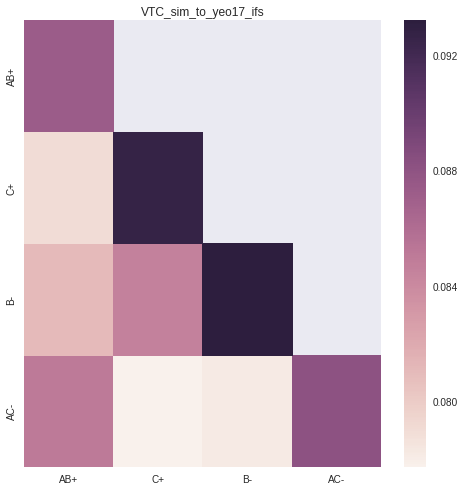

In [650]:
make_fig([x_roi,y_roi],all_cnf)

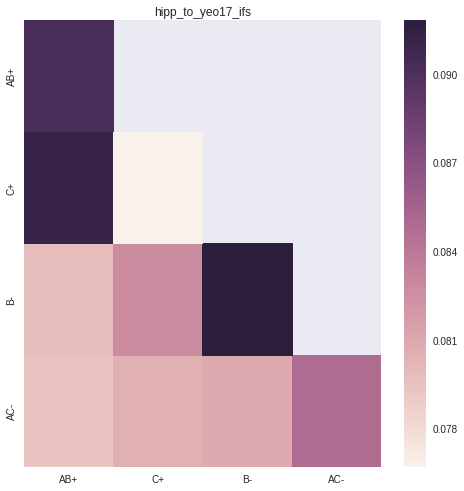

In [647]:
make_fig([x_roi,y_roi],all_cnf)

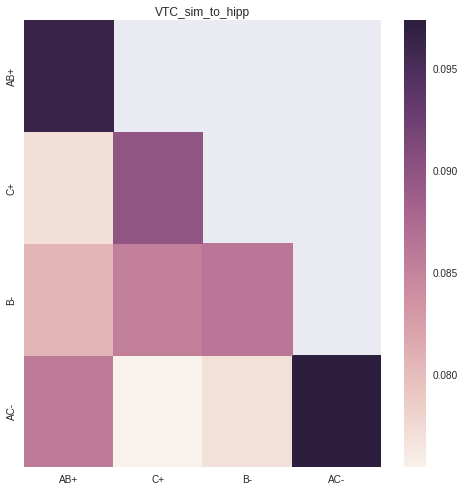

In [652]:
make_fig([x_roi,y_roi],all_cnf)

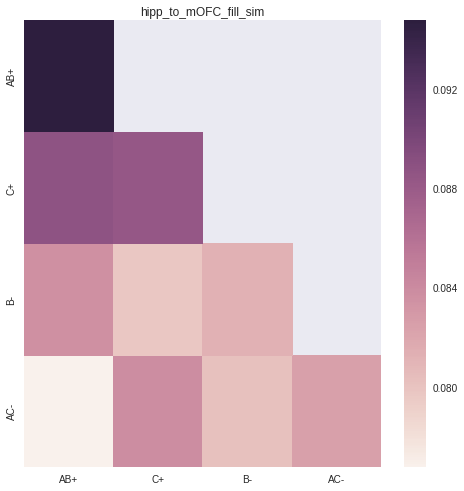

In [664]:
make_fig([x_roi,y_roi],all_cnf)